In [1]:
import mne
import os
import scipy.io
import listen_italian_functions
import numpy as np
from matplotlib import pyplot as plt
import pandas as pd
import warnings
warnings.filterwarnings('ignore')
from tqdm import tnrange, tqdm_notebook
import seaborn as sns
import matplotlib as mpl
from scipy import stats
from mne.stats import bonferroni_correction, fdr_correction

sns.set(style="darkgrid")
sns.set(font_scale=1.5)

data_path = os.path.dirname(os.getcwd())

subject_name = ['Alice','Andrea','Daniel','Elena','Elenora','Elisa','Federica','Francesca','Gianluca1','Giada','Giorgia',
                'Jonluca','Laura','Leonardo','Linda','Lucrezia','Manu','Marco','Martina','Pagani','Pasquale','Sara',
                'Silvia','Silvia2','Tommaso']

save_path = data_path + '/data/coherence'
info = mne.io.read_raw_fif((save_path+'-info'),preload=True)

remove_first = 0.5 #seconds


Opening raw data file C:\Users\SMukherjee\Desktop\projects\listen_italian_motor_entrainment\analysis\python\data\coherence-info...
This filename (C:\Users\SMukherjee\Desktop\projects\listen_italian_motor_entrainment\analysis\python\data\coherence-info) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, raw.fif.gz, raw_sss.fif.gz or raw_tsss.fif.gz
    Range : 40502 ... 1132918 =     40.502 ...  1132.918 secs
Ready.
Reading 0 ... 1092416  =      0.000 ...  1092.416 secs...


# read partial coherence

In [2]:
save_path = data_path + '/data/partialCoh/PartialCoh-removedFirst-'+ str(remove_first)+'.pkl'
data=pd.read_pickle(save_path)

data.set_index(['Feature','FeatureDelay','RemoveFeature','RemoveFeatureDelay',
                        'Freq','Condition','Subject'], inplace=True)
data.sort_index(inplace=True)

a  = data['Data'].apply(lambda x: np.mean(x))
data['partialCoh'] = pd.Series(a, index=data.index)
data.sample(5)

Data  \
Feature      FeatureDelay RemoveFeature RemoveFeatureDelay Freq       Condition Subject                                                       
lipaparature  0.2         envelop        0.2               fr 1 - 3Hz All       Silvia    [0.0007303474201188479, 0.00012145574118475097...   
envelop      -0.3         lipaparature  -0.3               fr 4 - 6Hz All       Elenora   [7.77186852713198e-05, 0.0002783451699148231, ...   
lipaparature  0.2         envelop        0.2               fr 1 - 3Hz All       Pagani    [0.0008378528235384738, 5.1707607786067336e-05...   
              0.0         envelop        0.0               fr 4 - 6Hz All       Federica  [9.989306162950474e-05, 0.0007462375429402942,...   
              0.5         envelop        0.5               fr 1 - 3Hz All       Lucrezia  [0.0011114944882455817, 0.0015122538525457886,...   

                                                                                          partialCoh  
Feature      FeatureDelay RemoveFeature RemoveFeatureDelay Freq       Condition Subject               
lipaparature  0.2         envelop        0.2               fr 1 - 3Hz All       Silvia      0.001870  
envelop      -0.3         lipaparature  -0.3               fr 4 - 6Hz All       Elenora     0.000744  
lipaparature  0.2         envelop        0.2               fr 1 - 3Hz All       Pagani      0.000557  
              0.0         envelop        0.0               fr 4 - 6Hz All       Federica    0.000287  
              0.5         envelop        0.5               fr 1 - 3Hz All       Lucrezia    0.000695

,Condition,Delay,Freq,p-value
0,All,-0.5,fr 1 - 3Hz,0.773
0,All,-0.4,fr 1 - 3Hz,0.632
0,All,-0.3,fr 1 - 3Hz,0.230
0,All,-0.2,fr 1 - 3Hz,0.523
0,All,-0.1,fr 1 - 3Hz,0.471
0,All,0.0,fr 1 - 3Hz,0.012
0,All,0.1,fr 1 - 3Hz,0.836
0,All,0.2,fr 1 - 3Hz,0.001
0,All,0.3,fr 1 - 3Hz,0.000
0,All,0.4,fr 1 - 3Hz,0.000


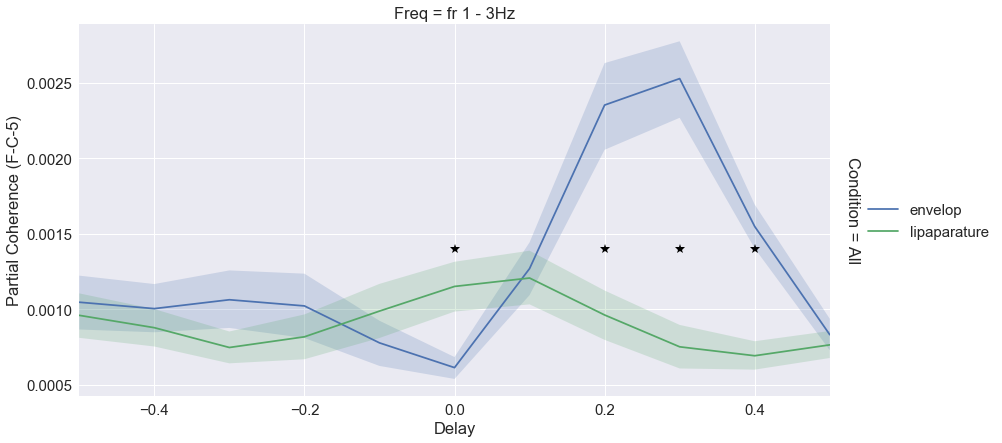

In [3]:
freq_band = [ 'fr 1 - 3Hz']
#freq_band = ['fr 1 - 3Hz', 'fr 2 - 4Hz', 'fr 3 - 5Hz', 'fr 4 - 6Hz','fr 5 - 7Hz', 'fr 6 - 8Hz', 'fr 7 - 9Hz', 'fr 8 - 10Hz',
# 'fr 9 - 11Hz', 'fr 10 - 12Hz']

features = ['envelop','jawaopening','lipaparature','lipProtrusion','TTCD','TMCD','TBCD']

features = ['envelop','lipaparature']
Removedfeatures = ['envelop','lipaparature']
feat_comb = (['envelop','lipaparature'],['lipaparature','envelop'])

condition = ['Hyper','Normal','Hypo','All']
condition = ['All']

delay = np.arange(-5,6) / 10

# select the best one Channel
column_name = ('FC5')

i = info.ch_names.index(column_name)
a  = data['Data'].apply(lambda x: np.mean(x[i]))
#data['partialCoh'] = pd.Series(a, index=data.index)



frame  = []
for d in delay:
    a = data.loc[features,d,Removedfeatures,d,freq_band,condition,subject_name]['partialCoh']
    frame.append(pd.DataFrame(a))
    
aa = pd.concat((frame),axis=0)

a = aa.loc[features,delay,Removedfeatures,delay,freq_band,condition,subject_name]['partialCoh']
a = pd.DataFrame(a.reset_index())


# stat
P = listen_italian_functions.get_P_value2(aa,feat_comb,freq_band,condition,delay,subject_name)
x = P[P['p-value'] <= 0.05]['Delay'].get_values()
y = np.repeat(0.0014,len(x))

g = sns.FacetGrid(a, col="Freq", row="Condition",col_order=freq_band , margin_titles=True,size=6,aspect=2)
b = g.map_dataframe(sns.tsplot, time="FeatureDelay", unit="Subject",condition="Feature", value='partialCoh',color="deep").add_legend()
b = b.set_xlabels('Delay')
b = b.set_ylabels('Partial Coherence ('+'-'.join(column_name)+')')
# mark the signifiancant point
x = plt.plot(x,y, marker='*', color='k',markersize=10,linestyle='')
P

# topo plot (should be done on two features and 1 freq at a time)¶

In [133]:
def get_coherence_value1(data,Feature,Removedfeatures,Freq,condition,Delay,subject_name):
    x=[]
    for f in Feature:
        for rf in Removedfeatures:
            for fr in Freq:
                for c in condition:
                    for d in Delay:
                        a  = data.loc[f,d,rf,d,fr,c,subject_name].as_matrix().mean(axis=0)
                        #if(!np.isnan(a).any())
                        x.append(a[0])
    return x

def draw_heatmap(*args, **kwargs):
    data = kwargs.pop('data')
    x = data['Data'].mean()
    mne.viz.plot_topomap(x, info.info, show=False,vmin=vmin,vmax=vmax)

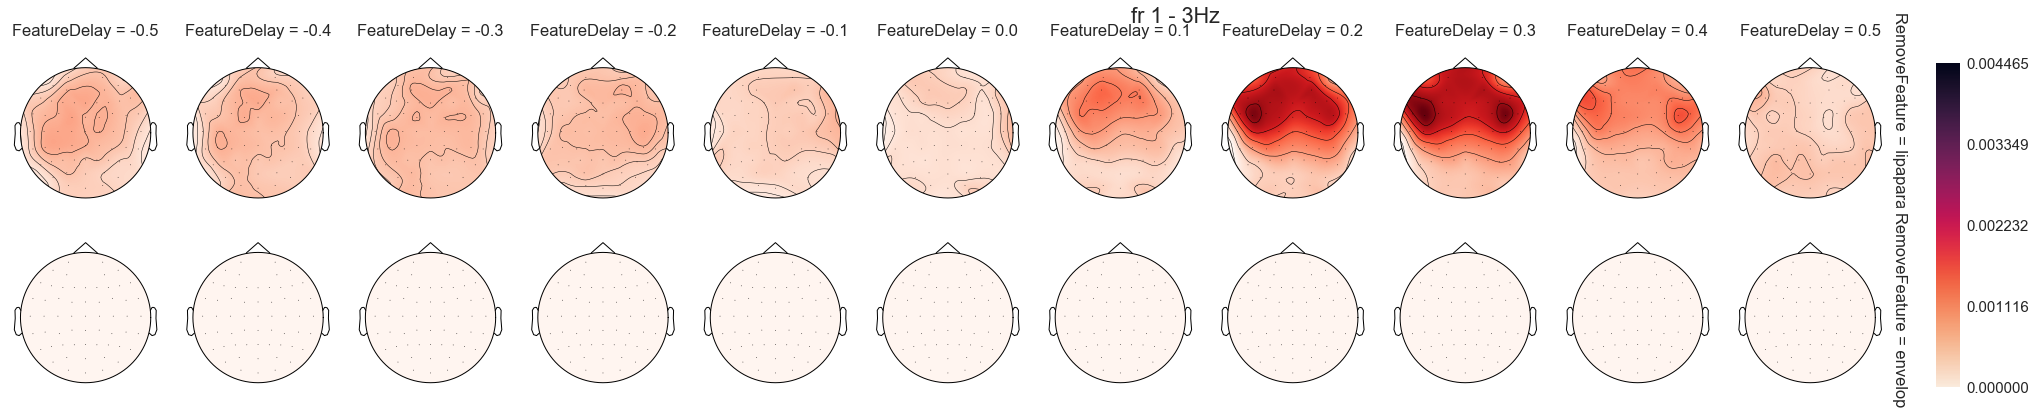

In [134]:
#freq_band = ['fr 1 - 3Hz', 'fr 2 - 4Hz', 'fr 3 - 5Hz', 'fr 4 - 6Hz','fr 5 - 7Hz', 'fr 6 - 8Hz', 'fr 7 - 9Hz', 'fr 8 - 10Hz',
# 'fr 9 - 11Hz', 'fr 10 - 12Hz']

freq_band = ['fr 1 - 3Hz']

features = ['envelop','jawaopening','lipaparature','lipProtrusion','TTCD','TMCD','TBCD']
features = ['envelop','lipaparature']

Removedfeatures = ['envelop','lipaparature']

condition = ['Hyper','Normal','Hypo','All']
condition = ['All']

delay = np.arange(-5,6) / 10

A = get_coherence_value1(data,features,Removedfeatures,freq_band,condition,delay,subject_name)
A = A[11:-12]
vmax=np.amax(np.concatenate(A, axis=0))
vmin=np.amin(np.concatenate(A, axis=0))

a = data.loc[features,delay,Removedfeatures,delay,freq_band,condition,subject_name]['Data']
a = pd.DataFrame(a.reset_index())


fg = sns.FacetGrid(a, col='FeatureDelay', row = 'RemoveFeature',margin_titles=True)
b = fg.map_dataframe(draw_heatmap, 'Data')
b = b.set_xlabels('')
b.fig.subplots_adjust(top=0.9)
b.fig.subplots_adjust(right=0.8)
b.fig.suptitle(freq_band[0])

cbar_ax = b.fig.add_axes([0.82,0.10,0.01,0.75])

#colorbar
cmap = plt.get_cmap()
norm = mpl.colors.Normalize(vmin=vmin,vmax=vmax)
sm = plt.cm.ScalarMappable(cmap=cmap.reversed(), norm=norm)
sm.set_array([])
plt.colorbar(sm, ticks=np.linspace(vmin,vmax,5),cax=cbar_ax)

# cluster permutation on original - surrogate coherence  

In [139]:

# read surrogate coherence
save_path = data_path + '/data\partialCoh/Surrogate_PartialCoh-removedFirst-0.5-envelop-lipaparature.pkl'
surrogate_data=pd.read_pickle(save_path)
surrogate_data.set_index(['Feature','FeatureDelay','RemoveFeature','RemoveFeatureDelay',
                        'Freq','Condition','Subject'], inplace=True)
surrogate_data.sort_index(inplace=True)
surrogate_data.head()


Data
Feature FeatureDelay RemoveFeature RemoveFeatureDelay Freq       Condition Subject                                                   
envelop -0.5         lipaparature  -0.5               fr 1 - 3Hz All       Alice    [0.0007747782750652913, 0.000753971236956606, ...
                                                                           Andrea   [0.0005555950045760848, 0.0005468940416260895,...
                                                                           Daniel   [0.0007153776540113236, 0.0006519020758007913,...
                                                                           Elena    [0.0007625604496873018, 0.000738133096809164, ...
                                                                           Elenora  [0.0007192004262631829, 0.000679450747551206, ...

In [ ]:
def compute_cluster_permutation_coherence_surrogate(data,data_surrogate,extra_channels,freq_band,condition,delay,subject_name):
    condition1 = data.loc[extra_channels,freq_band,condition,delay,subject_name]['Data'].get_values()
    condition2 = data_surrogate.loc[extra_channels,freq_band,condition,delay,subject_name]['Data'].get_values()
    condition1 = np.vstack(condition1)
    condition2 = np.vstack(condition2)
    condition1 = condition1[:, :, np.newaxis]
    condition2 = condition2[:, :, np.newaxis]

    #connectivity, ch_names = mne.channels.find_ch_connectivity(info.info, ch_type='eeg')
    fname = os.path.dirname(os.path.dirname(os.getcwd())) + '/fieldtrip_eeg_clean\mat/acticap-64ch-standard2_ferrara_neighb_for_mne.mat'
    connectivity ,ch_names = mne.channels.read_ch_connectivity(fname)
    threshold =6
    #T_obs, clusters, cluster_p_values, H0 = permutation_cluster_test([condition1, condition2],
                                                                    #n_permutations=500, out_type='indices',
                                                                           #connectivity = connectivity)
    
    
    condition1 = condition1 - condition2
    
    #T_obs, clusters, cluster_p_values, H0 = permutation_cluster_1samp_test(condition1,n_permutations=1000, out_type='indices',connectivity = connectivity)
    
    stat_fun_hat = partial(ttest_1samp_no_p, sigma=1e-3)
    threshold_tfce = dict(start=0, step=0.2)
    T_obs, clusters, cluster_p_values, H0 = permutation_cluster_1samp_test(condition1,n_permutations=1000, out_type='indices',
                                                                       connectivity = connectivity,stat_fun=stat_fun_hat,
                                                                       threshold=threshold_tfce)
    
    
    
    a=[]
    for i in range(0,len(clusters)):
        if cluster_p_values[i]<=0.05:
            print('----------+++++++++++++++++++++-------'+str(cluster_p_values[i]))
            a = np.append(a,clusters[i][0])

    a = np.sort(a)
    a = a.astype(int)
    mask = np.full((1, 59), False)[0]
    mask[a] = True
    
    T_obs = np.squeeze(T_obs)
    return T_obs, mask



def compute_ttest_coherence_surrogate(data,data_surrogate,extra_channels,freq_band,condition,delay,subject_name):
    condition1 = data.loc[extra_channels,freq_band,condition,delay,subject_name]['Data'].get_values()
    condition2 = data_surrogate.loc[extra_channels,freq_band,condition,delay,subject_name]['Data'].get_values()
    condition1 = np.vstack(condition1)
    condition2 = np.vstack(condition2)

    #connectivity, ch_names = mne.channels.find_ch_connectivity(info.info, ch_type='eeg')
    fname = os.path.dirname(os.path.dirname(os.getcwd())) + '/fieldtrip_eeg_clean\mat/acticap-64ch-standard2_ferrara_neighb_for_mne.mat'
    connectivity ,ch_names = mne.channels.read_ch_connectivity(fname)
    
    condition1 = condition1 - condition2
    T0, p_values, H0 = permutation_t_test(condition1, 1000, n_jobs=1)
    p_values = fdr_correction(p_values)

    a = np.where(p_values[1]<=0.05)
    a = a[0]


    a = np.sort(a)
    a = a.astype(int)
    mask = np.full((1, 59), False)[0]
    mask[a] = True
    
    T0 = np.squeeze(T0)
    return T0, mask

def plot_significant_coherence_channel_delay(data,data_surrogate,extra_channels,freq_band,condition,d,subject_name,A):
    frames = []
    for d in range(0,len(delay)):
        T_obs, mask = compute_cluster_permutation_coherence_surrogate(data,data_surrogate,extra_channels,
                                                             freq_band,condition,delay[d],subject_name)
        df = pd.DataFrame({'Data':[A[d]],'mask':[mask],'T-stat':[T_obs],'Delay':delay[d]})
        frames.append(df)
        
    df=pd.concat((frames),axis=0)
    return df

In [144]:
A

[]

In [143]:
#freq_band = ['fr 1 - 3Hz', 'fr 2 - 4Hz', 'fr 3 - 5Hz', 'fr 4 - 6Hz','fr 5 - 7Hz', 'fr 6 - 8Hz', 'fr 7 - 9Hz', 'fr 8 - 10Hz',
# 'fr 9 - 11Hz', 'fr 10 - 12Hz']

freq_band = ['fr 1 - 3Hz']

features = ['envelop','jawaopening','lipaparature','lipProtrusion','TTCD','TMCD','TBCD']
features = ['envelop']

Removedfeatures = ['lipaparature']

condition = ['Hyper','Normal','Hypo','All']
condition = ['All']

delay = np.arange(-5,6) / 10



A = get_coherence_value1(data,features,Removedfeatures,freq_band,condition,delay,subject_name)
A = A[11:-12]
vmax=np.amax(np.concatenate(A, axis=0))
vmin=np.amin(np.concatenate(A, axis=0))

sig_A = plot_significant_coherence_channel_delay(data,surrogate_data,extra_channels,freq_band,condition,delay,subject_name,A)
clear_output()  


ValueError: need at least one array to concatenate

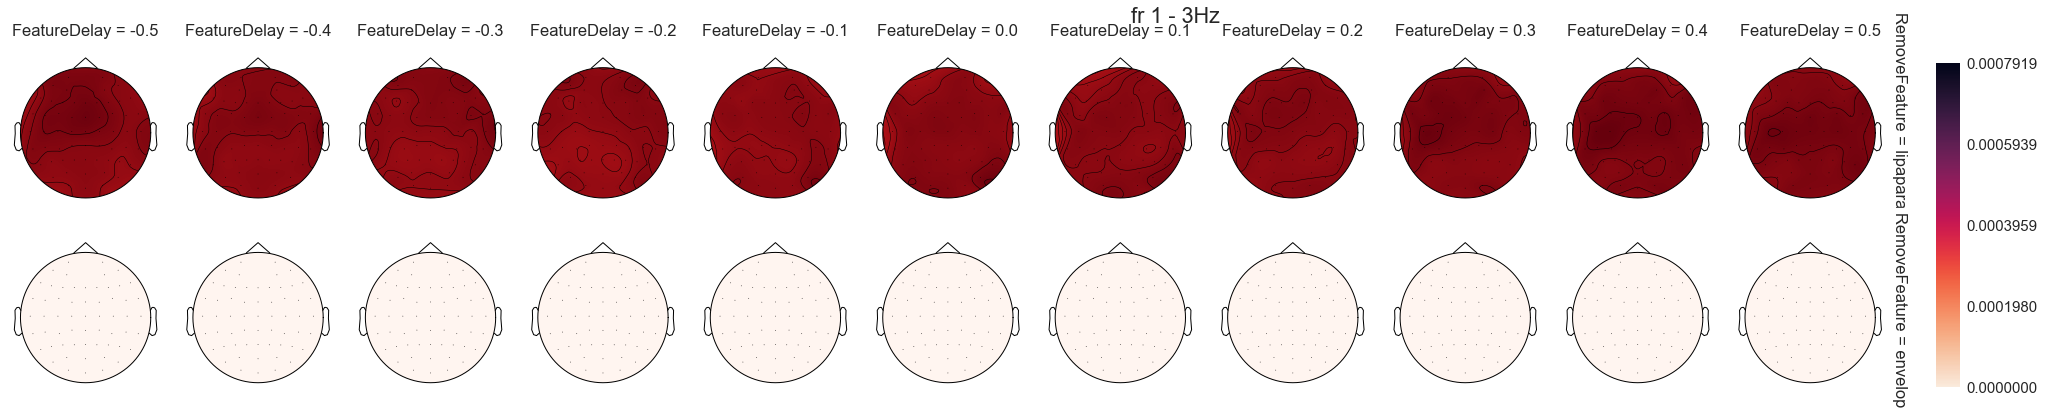

In [141]:
A = get_coherence_value1(surrogate_data,features,Removedfeatures,freq_band,condition,delay,subject_name)
A = A[11:-12]
vmax=np.amax(np.concatenate(A, axis=0))
vmin=np.amin(np.concatenate(A, axis=0))

a = surrogate_data.loc[features,delay,Removedfeatures,delay,freq_band,condition,subject_name]['Data']
a = pd.DataFrame(a.reset_index())


fg = sns.FacetGrid(a, col='FeatureDelay', row = 'RemoveFeature',margin_titles=True)
b = fg.map_dataframe(draw_heatmap, 'Data')
b = b.set_xlabels('')
b.fig.subplots_adjust(top=0.9)
b.fig.subplots_adjust(right=0.8)
b.fig.suptitle(freq_band[0])

cbar_ax = b.fig.add_axes([0.82,0.10,0.01,0.75])

#colorbar
cmap = plt.get_cmap()
norm = mpl.colors.Normalize(vmin=vmin,vmax=vmax)
sm = plt.cm.ScalarMappable(cmap=cmap.reversed(), norm=norm)
sm.set_array([])
plt.colorbar(sm, ticks=np.linspace(vmin,vmax,5),cax=cbar_ax)

# delayed Partial coherence

In [7]:
save_path = data_path + '/data/partialCoh/Delayed_partialCoh-removedFirst-'+ str(remove_first)+'.pkl'
delayed_data=pd.read_pickle(save_path)
delayed_data.set_index(['Feature','FeatureDelay','RemoveFeature','RemoveFeatureDelay',
                        'Freq','Condition','Subject'], inplace=True)
delayed_data.sort_index(inplace=True)
a  = delayed_data['Data'].apply(lambda x: np.mean(x))
delayed_data['partialCoh'] = pd.Series(a, index=delayed_data.index)
delayed_data.sample(5)


save_path = data_path + '/data/partialCoh/PartialCoh-removedFirst-'+ str(remove_first)+'.pkl'
data=pd.read_pickle(save_path)
data.set_index(['Feature','FeatureDelay','RemoveFeature','RemoveFeatureDelay',
                        'Freq','Condition','Subject'], inplace=True)
data.sort_index(inplace=True)
a  = data['Data'].apply(lambda x: np.mean(x))
data['partialCoh'] = pd.Series(a, index=data.index)

In [8]:
# select the best one Channel
column_name = ('FC5')

i = info.ch_names.index(column_name)
a  = data['Data'].apply(lambda x: np.mean(x[i]))
#data['partialCoh'] = pd.Series(a, index=data.index)

a  = delayed_data['Data'].apply(lambda x: np.mean(x[i]))
#delayed_data['partialCoh'] = pd.Series(a, index=delayed_data.index)


freq_band = ['fr 1 - 3Hz']

condition = ['All']

Text(0.5,0.98,'fr 1 - 3Hz')

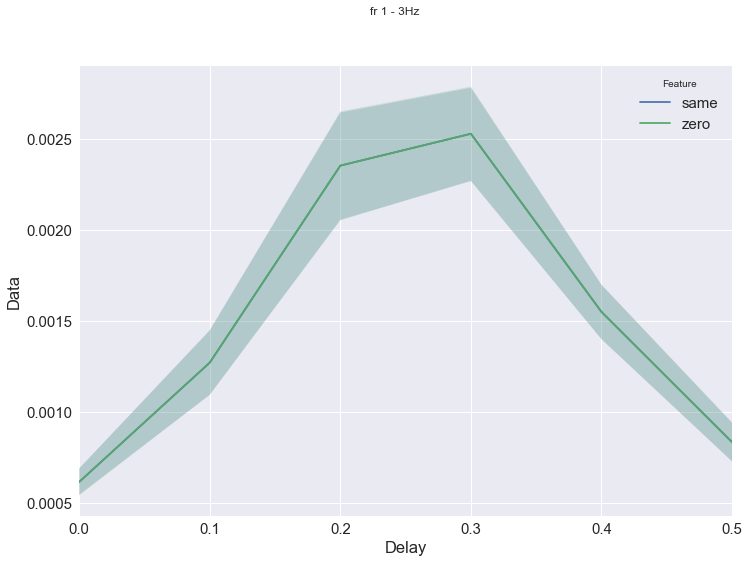

In [11]:

et = np.arange(0,0.6,0.1)
A = []
for t in et:
    t = t.round(decimals=1)
    x = data.loc['envelop',t,'lipaparature',t,freq_band,condition,subject_name]['partialCoh']
    y = delayed_data.loc['envelop',t,'lipaparature',0,freq_band,condition,subject_name]['partialCoh']
    
    p = listen_italian_functions.run_permutation_test2(x.get_values(),y.get_values(),1000)
    a=0
    #a,p = stats.ttest_rel(x.get_values(),y.get_values())

    #reject_fdr, p = fdr_correction(p, alpha=0.05, method='indep')

    
    frame = []
    for s in range(0,len(subject_name)):
        frame.append(pd.DataFrame({'Delay':t,'Feature':'same','Subject':subject_name[s],'p-value':p,'t-stat':a,'Data':[x[s]]}))
        frame.append(pd.DataFrame({'Delay':t,'Feature':'zero','Subject':subject_name[s],'p-value':p,'t-stat':a,'Data':[y[s]]}))

    a = pd.concat((frame),axis=0)    
    A.append(a)
    
data_partial = pd.concat((A),axis=0)    

x = data_partial[data_partial['p-value'] <= 0.05]['Delay'].get_values()
y = np.repeat(0.0014,len(x))

fig, ax = plt.subplots(figsize=(11.7, 8.27))
b=sns.tsplot(data=data_partial,time="Delay", unit="Subject",condition="Feature", value='Data',ax=ax)
# mark the signifiancant point
x = plt.plot(x,y, marker='*', color='k',markersize=10,linestyle='')
b.figure.suptitle(freq_band[0])

In [127]:
delayed_data = data

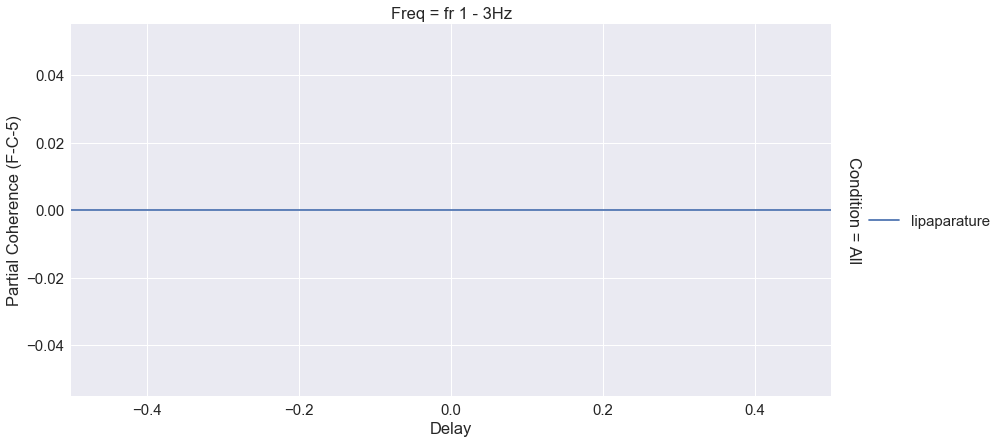

In [129]:
freq_band = [ 'fr 1 - 3Hz']
#freq_band = ['fr 1 - 3Hz', 'fr 2 - 4Hz', 'fr 3 - 5Hz', 'fr 4 - 6Hz','fr 5 - 7Hz', 'fr 6 - 8Hz', 'fr 7 - 9Hz', 'fr 8 - 10Hz',
# 'fr 9 - 11Hz', 'fr 10 - 12Hz']

features = ['envelop','jawaopening','lipaparature','lipProtrusion','TTCD','TMCD','TBCD']

features = ['lipaparature']
Removedfeatures = ['envelop','lipaparature']
feat_comb = (['envelop','lipaparature'],['lipaparature','envelop'])

condition = ['Hyper','Normal','Hypo','All']
condition = ['All']

delay = np.arange(-5,6) / 10

# select the best one Channel
column_name = ('FC5')

i = info.ch_names.index(column_name)
a  = delayed_data['Data'].apply(lambda x: np.mean(x[i]))
#delayed_data['partialCoh'] = pd.Series(a, index=delayed_data.index)



frame  = []
for d in delay:
    a = delayed_data.loc[features,d,Removedfeatures,d,freq_band,condition,subject_name]['partialCoh']
    frame.append(pd.DataFrame(a))
    
aa = pd.concat((frame),axis=0)

a = aa.loc[features,delay,Removedfeatures,delay,freq_band,condition,subject_name]['partialCoh']
a = pd.DataFrame(a.reset_index())


# stat
#P = listen_italian_functions.get_P_value2(aa,feat_comb,freq_band,condition,delay,subject_name)
#x = P[P['p-value'] <= 0.05]['Delay'].get_values()
#y = np.repeat(0.0014,len(x))

g = sns.FacetGrid(a, col="Freq", row="Condition",col_order=freq_band , margin_titles=True,size=6,aspect=2)
b = g.map_dataframe(sns.tsplot, time="FeatureDelay", unit="Subject",condition="Feature", value='partialCoh',color="deep").add_legend()
b = b.set_xlabels('Delay')
b = b.set_ylabels('Partial Coherence ('+'-'.join(column_name)+')')
# mark the signifiancant point
#x = plt.plot(x,y, marker='*', color='k',markersize=10,linestyle='')

# read the partial coherence from mat file

In [ ]:

# let's explore some frequency bands
iter_freqs = [
    ('fr', 1, 3),
    #('fr', 2, 4),
    #('fr', 3, 5),
    ('fr', 4, 6)
    #('fr', 5, 7),
    #('fr', 6, 8),
    #('fr', 7, 9),
    #('fr', 8, 10),
    #('fr', 9, 11),
    #('fr', 10, 12)
]

raw_fname = data_path + '/data/partialCoh/PartialCoherence_'+ str(remove_first)+'.mat'
mat = scipy.io.loadmat(raw_fname)

Feature= mat['data']['Feature'][0]
RemovedFeature= mat['data']['RemovedFeature'][0]
Condition= mat['data']['Condition'][0]
Delay= mat['data']['Delay'][0]
Frequency= mat['data']['Frequency'][0]
Subject= mat['data']['Subject'][0]
partialCoh= mat['data']['Data'][0]

Feature=np.concatenate( Feature[0][0,:], axis=0 )
RemovedFeature=np.concatenate( RemovedFeature[0][0,:], axis=0 )
Condition=np.concatenate( Condition[0][0,:], axis=0 )
Delay=np.concatenate( Delay[0][0,:], axis=0 )
Frequency=np.concatenate( Frequency[0][0,:], axis=0 )
Subject=np.concatenate( Subject[0][0,:], axis=0 )
    

frames = []
for i in range(0,len(Subject)):
    df = pd.DataFrame({'Feature':Feature[i],'RemovedFeature':RemovedFeature[i],'Condition':Condition[i],'Delay':Delay[i],
                 'Freq':Frequency[i],'Subject':Subject[i],'Data':[partialCoh[0][0][i][0]]})
    frames.append(df)
        
data=pd.concat((frames),axis=0)
data['Delay'] = data['Delay'].astype('float64')
data['Delay']=data['Delay'] - 0.5
data['Delay']=data['Delay'].round(decimals=1)

data.set_index(['Feature','RemovedFeature','Freq','Condition','Delay','Subject'], inplace=True)
data.sort_index(inplace=True)

a  = data['Data'].apply(lambda x: np.mean(x))
data['partialCoh'] = pd.Series(a, index=data.index)
data.sample(10)

In [ ]:
save_path = data_path + '/data/partialCoh/partialCoh_'+ str(remove_first)+'.pkl'
data.to_pickle(save_path)

# read partial coherence

In [ ]:
save_path = data_path + '/data/partialCoh/partialCoh_'+ str(remove_first)+'.pkl'
data=pd.read_pickle(save_path)
a = data.reset_index()
fr = a.Freq.unique()
print(fr)
data.head(10)

# seperate data in channels

In [ ]:
a = data.reset_index()
df = pd.DataFrame(np.column_stack(list(zip(*a.Data))), columns=info.ch_names)
data = pd.concat([a,df], axis=1)
data.set_index(['Feature','RemovedFeature','Freq','Condition','Delay','Subject'], inplace=True)
data.sort_index(inplace=True)
data.sample(5)

In [ ]:
freq_band = ['Delta 1 - 3Hz','Theta 4 - 7Hz','Alpha 8 - 12Hz','Beta 13 - 25Hz','Gamma 30 - 40Hz']
freq_band = ['Delta 1 - 3Hz','Theta 4 - 7Hz']
#freq_band = ['fr 1 - 3Hz', 'fr 2 - 4Hz', 'fr 3 - 5Hz', 'fr 4 - 6Hz','fr 5 - 7Hz', 'fr 6 - 8Hz', 'fr 7 - 9Hz', 'fr 8 - 10Hz',
# 'fr 9 - 11Hz', 'fr 10 - 12Hz']
freq_band = ['fr 1 - 3Hz', 'fr 4 - 6Hz']

features = ['envelop','jawaopening','lipaparature','lipProtrusion','TTCD','TMCD','TBCD']
features = ['envelop','lipaparature']

Removedfeatures = ['envelop','lipaparature']


condition = ['Hyper','Normal','Hypo','All']
condition = ['All']

delay = np.arange(-5,6) / 10

column_name = 'FC5'

a = data.loc[features,Removedfeatures,freq_band,condition,delay,subject_name][column_name]
a = pd.DataFrame(a.reset_index())

g = sns.FacetGrid(a, col="Freq", row="Condition",col_order=freq_band , margin_titles=True,size=6)
b = g.map_dataframe(sns.tsplot, time="Delay", unit="Subject",condition="Feature", value=column_name,color="deep").add_legend()
b = b.set_xlabels('Delay')
b = b.set_ylabels('Partial Coherence ('+column_name+')')

# permutation staticstics on delay time points (should be done on two features and 1 freq at a time)

In [ ]:
def run_permutation_test(x,y,numSamples):
    pooled = np.hstack([x,y])
    d0 = x.mean() - y.mean()
    d = np.zeros((numSamples,))
    for k in range(numSamples):
        np.random.shuffle(pooled)
        starZ = pooled[:len(x)]
        starY = pooled[-len(y):]    
        d[k] = starZ.mean() - starY.mean()
        
    p = len(np.where( d >= d0 )[0])
    p = p / float(numSamples)
    
    #t,p = stats.ttest_rel(x, y)
    #reject_fdr, p = fdr_correction(p, alpha=0.05, method='indep')

    return p.round(decimals=3)

def get_P_value(data,feat_comb,freq_band,condition,delay,numSamples):
    A = []    
    for c in condition:
        for fr in freq_band:        
            for d in delay:
                group1 = data.loc[feat_comb[0][0],feat_comb[0][1],fr,c,d,subject_name]['partialCoh']
                group2 = data.loc[feat_comb[1][0],feat_comb[1][1],fr,c,d,subject_name]['partialCoh']
                a = run_permutation_test(group1.get_values(),group2.get_values(),numSamples)
                p = pd.DataFrame({'Delay':d,'Freq':fr,'Condition':c,'p-value':[a]})
                A.append(p)
                
    P = pd.concat((A),axis=0)
    return P


def get_P_value_adaptive(data,feat_comb,freq_band,condition,delay,numSamples):
    A = []    
    for c in condition:
        for fr in freq_band:        
            for d in delay:
                group1 = data.loc[feat_comb[0][0],feat_comb[0][1],fr,c,d,subject_name]['Data']
                group2 = data.loc[feat_comb[1][0],feat_comb[1][1],fr,c,d,subject_name]['Data']
                
                aa1=np.where(group1.get_values().mean(axis=0)==group1.get_values().mean(axis=0).max())
                aa2=np.where(group2.get_values().mean(axis=0)==group2.get_values().mean(axis=0).max())
                
                group1 = data.loc[feat_comb[0][0],feat_comb[0][1],fr,c,d,subject_name][info.ch_names[aa1[0][0]]]
                group2 = data.loc[feat_comb[1][0],feat_comb[1][1],fr,c,d,subject_name][info.ch_names[aa2[0][0]]]

                a = run_permutation_test(group1.get_values(),group2.get_values(),numSamples)
                p = pd.DataFrame({'Delay':d,'Freq':fr,'Condition':c,'p-value':[a]})
                A.append(p)
                
    P = pd.concat((A),axis=0)
    return P



In [ ]:
find_value = lambda searchList, elem: [[i for i, x in enumerate(searchList) if x == e] for e in elem]
aa = find_value(info.ch_names,column_name)
i = np.asanyarray(aa).flatten()
a  = data['Data'].apply(lambda x: np.mean(x[i]))
data['partialCoh'] = pd.Series(a, index=data.index)

In [ ]:
freq_band = ['Delta 1 - 3Hz','Theta 4 - 7Hz','Alpha 8 - 12Hz','Beta 13 - 25Hz','Gamma 30 - 40Hz']
freq_band = [ 'fr 1 - 3Hz']
#freq_band = ['fr 1 - 3Hz', 'fr 2 - 4Hz', 'fr 3 - 5Hz', 'fr 4 - 6Hz','fr 5 - 7Hz', 'fr 6 - 8Hz', 'fr 7 - 9Hz', 'fr 8 - 10Hz',
# 'fr 9 - 11Hz', 'fr 10 - 12Hz']

features = ['envelop','jawaopening','lipaparature','lipProtrusion','TTCD','TMCD','TBCD']

features = ['envelop','lipaparature']
Removedfeatures = ['envelop','lipaparature']

feat_comb = (['envelop','lipaparature'],['lipaparature','envelop'])

condition = ['Hyper','Normal','Hypo','All']
condition = ['All']

delay = np.arange(-5,6) / 10

column_name = ('FC5')


i = info.ch_names.index(column_name)
a  = data['Data'].apply(lambda x: np.mean(x[i]))
#data['partialCoh'] = pd.Series(a, index=data.index)

a = data.loc[features,Removedfeatures,freq_band,condition,delay,subject_name]['partialCoh']
a = pd.DataFrame(a.reset_index())

# permutation stat
numSamples = 10000
P = get_P_value_adaptive(data,feat_comb,freq_band,condition,delay,numSamples)
x = P[P['p-value'] <= 0.05]['Delay'].get_values()
y = np.repeat(0.00014,len(x))

g = sns.FacetGrid(a, col="Freq", row="Condition",col_order=freq_band , margin_titles=True,size=6,aspect=2)
b = g.map_dataframe(sns.tsplot, time="Delay", unit="Subject",condition="Feature", value='partialCoh',color="deep").add_legend()
b = b.set_xlabels('Delay')
b = b.set_ylabels('Partial Coherence ('+'-'.join(column_name)+')')
# mark the signifiancant point
x = plt.plot(x,y, marker='*', color='k',markersize=10,linestyle='')

In [ ]:
subject_name = ['Alice','Andrea','Daniel','Elena','Elenora','Francesca','Gianluca1','Giada','Giorgia',
                'Jonluca','Laura','Leonardo','Linda','Lucrezia','Manu','Marco','Martina','Pagani','Pasquale','Sara',
                'Silvia2','Tommaso']
t=0
x = delayed_data.loc['envelop',t,'lipaparature',t,freq_band,condition,subject_name]['partialCoh']
y = delayed_data.loc['lipaparature',t,'envelop',t,freq_band,condition,subject_name]['partialCoh']
np.hstack([x,y])
sns.distplot(x,label='envelop')
sns.distplot(y,label='lipaparature')
plt.legend()



print(listen_italian_functions.run_permutation_test(x.get_values(),y.get_values(),10000))
stats.ttest_rel(x.get_values(),y.get_values())


In [ ]:

def get_P_value2(data,feat_comb,freq_band,condition,delay):
    A = []    
    for c in condition:
        for fr in freq_band:        
            for d in delay:
                group1 = data.loc[feat_comb[0][0],d,feat_comb[0][1],d,fr,c,subject_name]['partialCoh']
                group2 = data.loc[feat_comb[1][0],d,feat_comb[1][1],d,fr,c,subject_name]['partialCoh']
                p = run_permutation_test(group1.get_values(),group2.get_values(),10000)

                #t,p = stats.ttest_rel(group1.get_values(),group2.get_values())
                #reject_fdr, p = fdr_correction(p, alpha=0.05, method='indep')
                a = pd.DataFrame({'Delay':d,'Freq':fr,'Condition':c,'p-value':[p]})
                A.append(a)
                
    P = pd.concat((A),axis=0)
    return P

In [ ]:
def get_coherence_value_delay(data,name,subject_name,delay,condition): 
    D = []
    D_std = []
    for d in delay:
        A = []
        B=[]
        for c in condition:
            a  = data.loc[name[0],name[1],c,d,subject_name].as_matrix().mean(axis=0)
            A.append(a[0].mean())
            B.append(a[0].std())

        D.append(A)
        D_std.append(B)
        
    D=np.asarray(D)
    D_std=np.asarray(D_std)
    
    frames=[]
    frames1=[]
    for c in range(0,len(condition)):
        frames.append(pd.DataFrame({condition[c]:D[:,c]}))
        frames1.append(pd.DataFrame({condition[c]:D_std[:,c]}))
        
    df=pd.concat((frames),axis=1)
    df.index = delay
    df.index.name = 'Delay'
    
    df_std=pd.concat((frames1),axis=1)
    df_std.index = delay
    df_std.index.name = 'Delay'
    return df,df_std

def get_coherence_value(data,name,subject_name,d,condition):
    x=[]
    for i in condition:
        a  = data.loc[name[0],name[1],name[2],i,d,subject_name].as_matrix().mean(axis=0)
        x.append(a[0])

    return x

def plot_coherence(data,vmax,vmin,axes,name,info): 
    im = mne.viz.plot_topomap(data, info.info, axes=axes, show=False,vmin=vmin,vmax=vmax)
    axes.set(title=name)
    return im

def plot_coherence_preprocess(x,name,condition,delay,info):
    vmax=np.amax(np.concatenate(x, axis=0))
    vmin=np.amin(np.concatenate(x, axis=0))

    fig, axes = plt.subplots(1, len(condition),figsize=(10,4))
    for i in range(0,len(condition)):
        im = plot_coherence(x[i],vmax,vmin,axes[i],condition[i],info)

    fig.suptitle(name[0]+'-Delay-'+ str(delay)+ '-'+name[1])
    fig.subplots_adjust(right=0.8)
    cbar_ax = fig.add_axes([0.85, 0.35, 0.04, 0.3])
    fig.colorbar(im[0], cax=cbar_ax)
    fig.show()
    
def plot_coherence_preprocess_delay(x,name,condition,delay,info):
    vmax=np.amax(np.concatenate(x, axis=0))
    vmin=np.amin(np.concatenate(x, axis=0))

    fig, axes = plt.subplots(1, len(delay),figsize=(20,6))
    for i in range(0,len(delay)):
        im = plot_coherence(x[i][0],vmax,vmin,axes[i],delay[i],info)

    fig.suptitle(name[0]+ ' -Removed-'+name[1]+' - '+name[2]+'-'+ str(condition[0]),y=0.7)
    fig.subplots_adjust(right=0.8)
    cbar_ax = fig.add_axes([0.85, 0.50, 0.01, 0.15])
    fig.colorbar(im[0], cax=cbar_ax)
    fig.show()
    return fig
    

In [ ]:
freq_band = ['Delta 1 - 3Hz','Theta 4 - 7Hz','Alpha 8 - 12Hz','Beta 13 - 25Hz','Gamma 30 - 40Hz']
freq_band = ['Delta 1 - 3Hz','Theta 4 - 7Hz']
#freq_band = ['fr 1 - 3Hz', 'fr 2 - 4Hz', 'fr 3 - 5Hz', 'fr 4 - 6Hz','fr 5 - 7Hz', 'fr 6 - 8Hz', 'fr 7 - 9Hz', 'fr 8 - 10Hz',
# 'fr 9 - 11Hz', 'fr 10 - 12Hz']

freq_band = ['fr 1 - 3Hz', 'fr 4 - 6Hz']

features = ['envelop','jawaopening','lipaparature','lipProtrusion','TTCD','TMCD','TBCD']
features = ['lipaparature']

Removedfeatures = ['envelop']

condition = ['Hyper','Normal','Hypo','All']
condition = ['All']

delay = np.arange(-5,6) / 10


for f in freq_band:
    A = []
    for feat in features:
        name = (feat,Removedfeatures[0],f)
        for d in delay:
            a = get_coherence_value(data,name,subject_name,d,condition)
            A.append(a)
    a = plot_coherence_preprocess_delay(A,name,condition,delay,info)
    
